In [293]:
%time
import os
import keras
from keras.datasets import mnist

from sklearn import datasets
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn import metrics

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

CPU times: user 7 µs, sys: 4 µs, total: 11 µs
Wall time: 10 µs


In [294]:
(x_train, y_train), (x_test, y_test) = mnist.load_data();

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#training set
classes = np.unique(y_train)
n_samples = 200; #n_samples for each class

for i in range(len(classes)):
    x_train_i = x_train[y_train==i][0:n_samples]
    if (i==0):
        x_train_new = x_train_i
    else:
        x_train_new = np.concatenate((x_train_new, x_train_i), axis=0)

#labels training set
for i in range(len(classes)):
    y_train_i = y_train[y_train==i][0:n_samples]
    if (i==0):
        y_train_new = y_train_i
    else:
        y_train_new = np.concatenate((y_train_new, y_train_i), axis=0)
        
#test set
classes = np.unique(y_test)
n_samples_test = 20; #n_samples for each class

for i in range(len(classes)):
    x_test_i = x_test[y_test==i][0:n_samples_test]
    if (i==0):
        x_test_new = x_test_i
    else:
        x_test_new = np.concatenate((x_test_new, x_test_i), axis=0)

# labels test set
for i in range(len(classes)):
    y_test_i = y_test[y_test==i][0:n_samples_test]
    if (i==0):
        y_test_new = y_test_i
    else:
        y_test_new = np.concatenate((y_test_new, y_test_i), axis=0)

        
x_train = x_train_new
y_train = y_train_new
x_test = x_test_new
y_test = y_test_new


#normalization
x_train /= 255 
x_test /= 255

classes = np.unique(y_train);
num_classes = len(classes)

#convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

(2000, 'train samples')
(200, 'test samples')


In [295]:
def mean_inter_cluster_dist(cluster_centers, data):
    #cluster_centers = kmeans.cluster_centers_
    #mean_clusters = np.mean(cluster_centers,axis=0);
    mean_data = np.mean(data);
    n_clusters = np.shape(cluster_centers)[0];
    f_out = 0
    
    for k in range(n_clusters):
        #use mean of elements?
        squared_norm_diff = np.linalg.norm(cluster_centers[k]-mean_data,ord=2)**2
        #squared_norm_diff = np.linalg.norm(cluster_centers[k]-mean_clusters,ord=2)**2
        n_members = float(sum(output==k))
        f_out = f_out + n_members*squared_norm_diff

    return f_out

def davies_bouldin_index(cluster_centers, data, output): #output is the classification of the data
    #Davies-Bouldin Index
    #Dkj = (dk +dj)/dkj
    n_clusters = np.shape(cluster_centers)[0];
    new_DB = 0
    intra_mean = np.zeros([n_clusters,1])
    for k in range(n_clusters): #for each cluster
        dist = data[output==k]-cluster_centers[k]
        #norma 2 da distancia entre cada ponto do cluster e o centroid do msm
        intra_mean[k] = np.linalg.norm(dist,ord=2)/sum(output==k)
    Dkj = np.zeros([n_clusters,n_clusters])
    for k_cluster in range(n_clusters):
        for j_cluster in range(n_clusters):
            if (k_cluster==j_cluster):
                continue
            dist_clusters = np.linalg.norm(cluster_centers[k_cluster]-cluster_centers[j_cluster],ord=2)
            Dkj[k_cluster,j_cluster] = (intra_mean[k_cluster]+intra_mean[j_cluster])/dist_clusters
    
    DB_index = sum(np.max(Dkj,axis=0))/float(n_clusters)  
    
    return DB_index

In [299]:
%time
min_clusters = 10
max_clusters = 60

data = x_train;

intra_cluster = np.zeros([max_clusters,1])
f_out = np.zeros([max_clusters,1])
silhouette = np.zeros([max_clusters,1])
DB_index = np.zeros([max_clusters,1])
#output = np.zeros([max_clusters,len(data)])

for i in range(min_clusters, max_clusters):
    
    kmeans = KMeans(n_clusters=i).fit(data)  
    output = kmeans.predict(data)
    
    silhouette[i] = metrics.silhouette_score(data, output)
    
    #intra-cluster distance - dispersao intra classe 
    intra_cluster[i] = kmeans.inertia_
    
    #mean inter-cluster distance - dispersao media extra classe
    cluster_centers = kmeans.cluster_centers_
    f_out[i] = mean_inter_cluster_dist(cluster_centers,data)

    #Davies-Bouldin Index
    #Dkj = (dk +dj)/dkj
    DB_index[i] = davies_bouldin_index(cluster_centers, data, output)



CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs


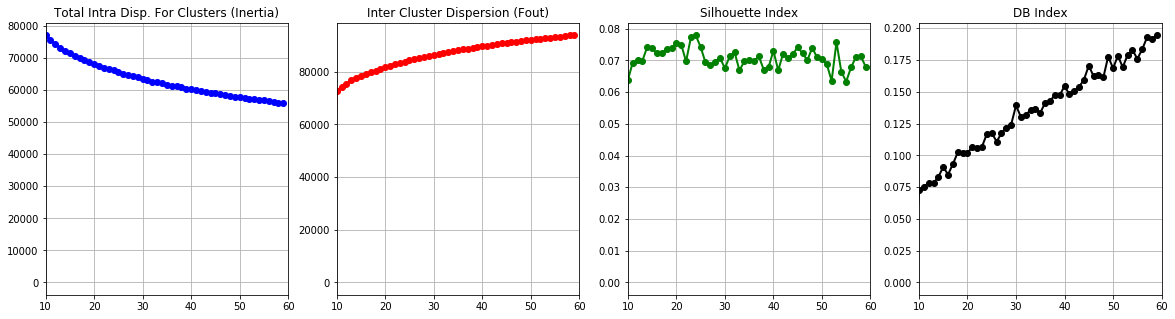

In [300]:
fig, ax = plt.subplots(figsize=(20,5),nrows=1, ncols=4)

ax[0].plot(range(max_clusters),intra_cluster,'bo-')
ax[0].set_xlim([min_clusters, max_clusters])
ax[0].set_title("Total Intra Disp. For Clusters (Inertia)")
ax[0].grid()

ax[1].plot(range(max_clusters),f_out,'ro-' ) #plot in the same graph as intra-cluster dispersion?
ax[1].set_xlim([min_clusters, max_clusters])
ax[1].set_title("Inter Cluster Dispersion (Fout)")
ax[1].grid()

ax[2].plot(range(max_clusters),silhouette,'go-')
ax[2].set_xlim([min_clusters, max_clusters])
ax[2].set_title("Silhouette Index")
ax[2].grid()

ax[3].plot(range(max_clusters),DB_index,'ko-')
ax[3].set_xlim([min_clusters, max_clusters])
ax[3].set_title("DB Index")
ax[3].grid()

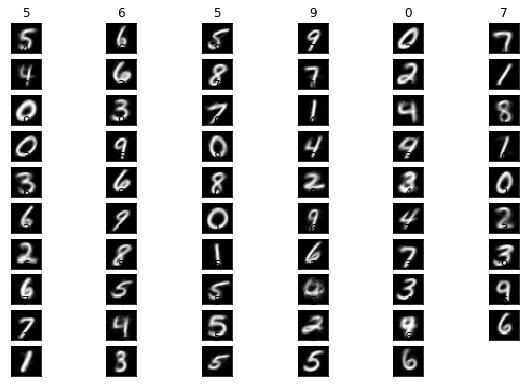

In [301]:
#showing cluster centers
n_clusters = np.shape(cluster_centers)[0]
most_freq = np.zeros(n_clusters)
for icluster in range(n_clusters):
    id_clusters = np.unique(output)
    labels = y_train[output==id_clusters[icluster]]

#    next 5 lines print cluster frequencies   
#     freq = np.bincount(np.argmax(labels, axis=1))

#     for i in range(len(freq)):
#         if (freq[i]):
#             print (str(i) + ": " + str(freq[i]))
#     print " "
    
    most_freq[icluster] = np.argmax(np.bincount(np.argmax(labels, axis=1)))
    
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
#plt.rcParams['xtick.labelsize'] = 18
#plt.rcParams['font.weight'] = 'bold'
#plt.rcParams['ytick.labelsize'] = 18

nrows = 10
ncols = 6
irow = 0
icolumn = 0
fig, ax = plt.subplots(figsize=(10,6.5),nrows=nrows, ncols=ncols)

for cluster in range(np.shape(cluster_centers)[0]):
    img = cluster_centers[cluster];
    img = img.reshape(28,28);

    ax[irow,icolumn].imshow(img,cmap='gray',interpolation="nearest")
    ax[irow,icolumn].set_title(str(int(most_freq[cluster])))
    ax[irow,icolumn].get_xaxis().set_visible(False)
    ax[irow,icolumn].get_yaxis().set_visible(False)
    
    if (icolumn+1 == ncols):
        icolumn = 0
        irow = irow + 1
    else:
        icolumn = icolumn + 1
        
if cluster < (nrows*ncols):
    for i in range(cluster,nrows*ncols-1):
        ax[irow,icolumn].set_visible(False)
        
        if (icolumn+1 == ncols):
            icolumn = 0
            irow = irow + 1
        else:
            icolumn = icolumn + 1


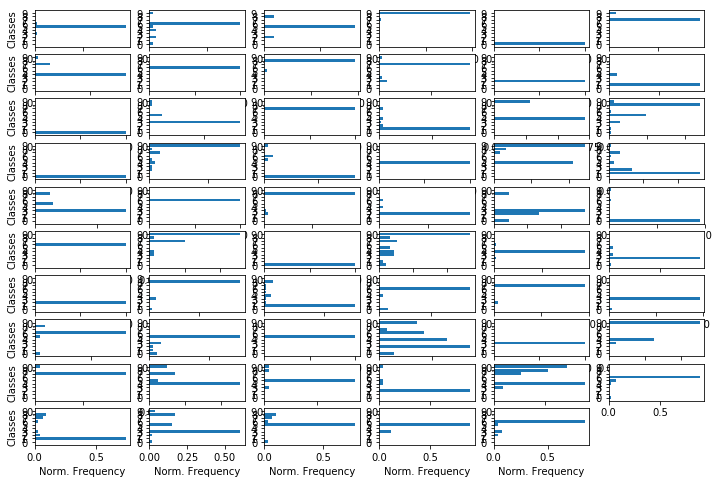

In [302]:
#showing cluster frequencies
n_clusters = np.shape(cluster_centers)[0]
most_freq = np.zeros(n_clusters)
freq = np.zeros([n_clusters, np.shape(y_train)[1]]) ##change to len(np.unique(np.argmax(y_train, axis=1)))

for icluster in range(n_clusters):
    id_clusters = np.unique(output)
    labels = y_train[output==id_clusters[icluster]]
    
    for iclass in range(len(np.unique(np.argmax(y_train, axis=1)))):
        freq[icluster,iclass]=np.sum(np.argmax(labels, axis=1)==iclass)
    
    most_freq[icluster] = np.argmax(np.bincount(np.argmax(labels, axis=1)))
    
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
#plt.rcParams['xtick.labelsize'] = 18
#plt.rcParams['font.weight'] = 'bold'
#plt.rcParams['ytick.labelsize'] = 18

nrows = 10
ncols = 6
irow = 0
icolumn = 0
fig, ax = plt.subplots(figsize=(12,8),nrows=nrows, ncols=ncols)

for cluster in range(np.shape(cluster_centers)[0]):
    val = freq[cluster,:]/np.sum(freq[cluster,:])
    pos = np.arange(len(np.unique(np.argmax(y_train, axis=1))))
    
    ax[irow,icolumn].barh(pos,val, align='center')
    ax[irow,icolumn].get_yaxis().set_ticks(pos)
    if (irow==nrows-1):
        ax[irow,icolumn].set_xlabel('Norm. Frequency')
    if (icolumn==0):
        ax[irow,icolumn].set_ylabel('Classes')

    if (icolumn+1 == ncols):
        icolumn = 0
        irow = irow + 1
    else:
        icolumn = icolumn + 1

if cluster < (nrows*ncols):
    for i in range(cluster,nrows*ncols-1):
        ax[irow,icolumn].set_visible(False)
        
        if (icolumn+1 == ncols):
            icolumn = 0
            irow = irow + 1
        else:
            icolumn = icolumn + 1


In [ ]:
#showing character

img = cluster_centers[1];
img = img.reshape(28,28);

#from matplotlib.legend_handler import HandlerLine2D

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 18


fig, ax = plt.subplots(figsize=(28,28),nrows=1, ncols=1)
ax.imshow(img,cmap='gray',interpolation="nearest")